# **Kaggle HW5: mnochi**

**Remember to write your team name above, which MUST match your team name on Kaggle!!** Assignments without a team name will receive a 0/40 on the "accuracy on test data" component of this assignment's grade.

### **Load the Data**

In [2]:
# This cell is necessary only if you are running on Google Colab. It downloads the files to your
# Colab instance so you don't have to upload them here.

import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_train.csv',
          'edx_train.csv')
save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_test.csv',
          'edx_test.csv')

### **Sample Code: Random Classifier**

**NOTE**: This classifier **DOES NOT** count as one of the 2 required for this assignment! It is merely here to illstrate how to submit your predictions.

See the Kaggle assignment (Data tab) for a description of each column in the dataset. You are creating a classifier to predict whether or not a student will get certified, stored in the `"certified"` column.

In [3]:
import pandas as pd
from sklearn.dummy import DummyClassifier

target = "certified" # target column

# This classifier returns labels sampled uniformly at random
df_train = pd.read_csv('edx_train.csv')
dummy_model = DummyClassifier(strategy="uniform")
dummy_model.fit(df_train.drop(target, axis=1), df_train[target])

DummyClassifier(strategy='uniform')

The code below generates predictions on the test set, and outputs the predictions into a CSV file.

In [4]:
# Generate predictions on the test set
df_test = pd.read_csv('edx_test.csv')
predictions = dummy_model.predict(df_test)

# Save your predictions as a CSV
to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = predictions
to_save.to_csv('submission.csv', index=False)

# See below for instructions on how to upload submission.csv to Kaggle,
# in order to evaluate your model and get points.

### **[5 Pts] Model Comparison**

**Instructions**: Run at least 2 different classification models. The classification models we have learned in class are: [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [Decision Trees](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), and [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [Neural Networks](https://scikit-learn.org/stable/modules/neural_networks_supervised.html). For each model, try at least 2 different hyperparameter settings.

Then, make one or more visualizations that let you compare the models you trained. Sample visualizations you can make include confusion matrices, or graphs of train and validation accuracy/error. See past section and homework code for how to make these visualizations.

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Load the data
df_train = pd.read_csv('edx_train.csv')
df_test = pd.read_csv('edx_test.csv')
target = "certified"
to_save = df_test[['userid_DI']].copy() # save for submission

# Preprocessing data
# Removing target category
y_train = df_train[target]
df_train = df_train.drop(target, axis=1)

# Changing start and end date to time_taken
df_train['start_time_DI'] = pd.to_datetime(df_train['start_time_DI'], format='%m/%d/%y')
df_train['last_event_DI'] = pd.to_datetime(df_train['last_event_DI'], format='%m/%d/%y')
df_test['start_time_DI'] = pd.to_datetime(df_test['start_time_DI'], format='%m/%d/%y')
df_test['last_event_DI'] = pd.to_datetime(df_test['last_event_DI'], format='%m/%d/%y')

df_train['time_taken'] = (df_train['last_event_DI'] - df_train['start_time_DI']).dt.days
df_test['time_taken'] = (df_test['last_event_DI'] - df_test['start_time_DI']).dt.days

df_train = df_train.drop(['start_time_DI', 'last_event_DI'], axis=1)
df_test = df_test.drop(['start_time_DI', 'last_event_DI'], axis=1)

# Splitting course_id to school, course, and year
df_train[['school', 'course', 'year']] = df_train['course_id'].str.split('/', expand=True)
df_test[['school', 'course', 'year']] = df_test['course_id'].str.split('/', expand=True)

# Removing userid_DI (doesn't provide useful info) & course_id (redundant)
df_train = df_train.drop(['course_id', 'userid_DI'], axis=1)
df_test = df_test.drop(['course_id', 'userid_DI'], axis=1)

# Changing categorical variables
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

# Align columns of test and train data
df_train, df_test = df_train.align(df_test, join='left', axis=1, fill_value=0)

# Dealing with NaNs
imputer = SimpleImputer(strategy='most_frequent')
df_train = imputer.fit_transform(df_train)
df_test = imputer.transform(df_test)

# Standardizing the data
scaler = StandardScaler().fit(df_train)
df_train_standardized = scaler.transform(df_train)
df_test_standardized = scaler.transform(df_test)

X_train, X_val, Y_train, Y_val = train_test_split(df_train_standardized, y_train, test_size=0.1)

# Train and Evaluate Models

# GridSearch with kNN
param_knn = {
    'n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 20, 30, 40, 50, 60, 70, 80]
}

search_knn = GridSearchCV(KNeighborsClassifier(), param_knn, cv=5, scoring='accuracy').fit(X_train, Y_train)
print("Best kNN parameters found: ", search_knn.best_params_)
print("Best kNN cross-validation accuracy: ", search_knn.best_score_)

# GridSearch with RandomForest
param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

search_rf = GridSearchCV(RandomForestClassifier(), param_rf, cv=5, scoring='accuracy').fit(X_train, Y_train)
print("Best RandomForest parameters found: ", search_rf.best_params_)
print("Best RandomForest cross-validation accuracy: ", search_rf.best_score_)

# GridSearch with AdaBoost
param_ada = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 1, 10]
}

search_ada = GridSearchCV(AdaBoostClassifier(), param_ada, cv=5, scoring='accuracy').fit(X_train, Y_train)
print("Best AdaBoost parameters found: ", search_ada.best_params_)
print("Best AdaBoost cross-validation accuracy: ", search_ada.best_score_)

# Best model
best_model = max(
    (search_knn, search_rf, search_ada),
    key=lambda gs: gs.best_score_
).best_estimator_

# Train model on full training set
best_model.fit(df_train_standardized, y_train)

# Submission

# Predictions
predictions = best_model.predict(df_test_standardized)

# Save your predictions as a CSV
to_save['certified'] = predictions
to_save.to_csv('submission.csv', index=False)


Best kNN parameters found:  {'leaf_size': 10, 'n_neighbors': 15, 'weights': 'distance'}
Best kNN cross-validation accuracy:  0.9300941677476672
Best RandomForest parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best RandomForest cross-validation accuracy:  0.9739910483504952
Best AdaBoost parameters found:  {'learning_rate': 1, 'n_estimators': 150}
Best AdaBoost cross-validation accuracy:  0.9640950658095916


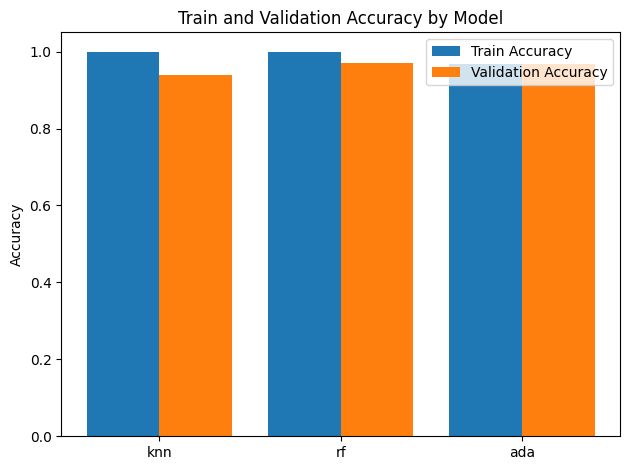

In [17]:
import matplotlib.pyplot as plt

models = [
    search_knn.best_estimator_,
    search_rf.best_estimator_,
    search_ada.best_estimator_
]

train_accuracies = []
val_accuracies = []

for model in models:
    model.fit(X_train, Y_train)
    train_accuracy = accuracy_score(Y_train, model.predict(X_train))
    val_accuracy = accuracy_score(Y_val, model.predict(X_val))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Visualization
labels = ['knn', 'rf', 'ada']
x = np.arange(len(labels))
fig, ax = plt.subplots()
width = 0.4

rects1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
rects2 = ax.bar(x + width/2, val_accuracies, width, label='Validation Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Train and Validation Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()


**Remember to submit your submissions CSV FILE on Kaggle!** 40 pts come from your accuracy on the private test data.

Attend section on Thurs 5/11 for a demo of how to uppload submissions to Kaggle. We also have screenshots below (ingore summer and homework number in pictures)

Step 1: See the list of files on Colab

![See Colab Files](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/1_colab_see_files.jpg)

Step 2: Download `submission.csv`

![Download Colab File](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/2_colab_download_file.jpg)

Step 3: Join the Kaggle competition.

![Join the Kaggle Competition](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/3_kaggle_join_competition.jpg)

Step 4: Enusre your team name in Kaggle matches the one at the top of this notebook!

![Check Team Name](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/4_kaggle_team_name.jpg)

Step 5: Upload `submission.csv` to Kaggle

![Upload submission.csv](https://courses.cs.washington.edu/courses/cse416/22su/homework/hw4/programming/6_kaggle_upload_submission.jpg)



### **Discussion**



#### **[7 Pts] Training the Models**

**Instructions**: Discuss what models you tried, and what you did to improve your initial predictions. Discuss what hyperparameters you tried, and which hyperparameters seemed important for your final model. Finally, discuss what you are inferring from the above visualiation(s).

I had originally thought that kNN would be the best model, so I originally spent most of my time tuning the hyperparameters with that model, and the best accuracy I could get was around 91%-92%. Then I realized that I could use grid search, so I implemented that and got 93% accuracy. Then I decided to use a new model, random forest and adaboost. I implemented grid search for hyperparameters to figure out the best model. For random forest, which was the model I ended up using, I looked at nearly all the hyperparameters - max depth, min samples split, min samples leaf, and number of estimators. Honestly, when looking at the sklearn guide for random forest, I could've worked with more hyperparaters, but it was already the longest model to train, sometimes taking more than 5 minutes. Looking at the data the most important hyperparameters were the ones that defined the structure of the tree (max depth, min samples split, min samples leaf). Lastly, looking at the visualization, I can clearly see that the validation accuracy of the best random forest model is the best, next is the adaboost, and last is kNN.

#### **[3 Pts] Feature Selection**

**Instructions**: Discuss what features you used and whether you did some transformations on them. What features seemed important for your final model?



For features, I tried to use all of them, but I did adjust the data. First, I changed the start and end date to total time taken, I removed the userID (since everyone is unique), I split the courseID to school, course, and year. In terms of which features seemed important for my final model, I believe that all of them were important, my model did not use feature selection, I only preprocessed the data a little bit.

#### **[5 Pts] Ethical Implications**

**Instructions**: Consider and discuss the ethical implications of using the model you trained. Imagine you were hired to work as a data scientist for an online education platform (exciting, right?). They want to use your model to predict which students they should tailor their course material towards so they can maximize their profits. Their idea is to use the model to help predict which student groups (i.e. from specific countries or certain educational backgrounds) would make them the most money by getting the most participants to complete their paid certificate program. Are there any ethical considerations we should think about before acting on that plan?

A model like this could introduce bias, which would result in unfair treatment for some groups of people. This could lead to discrimination. Additionally students should be made aware that their data is being used for their future course material. Lastly, but most importantly, I believe taht maximizing profit shouldn't be sole factor when dealing with a topic as sensitive as a student's education.